In [101]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import Category10
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [102]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm.csv", index_col=0, usecols=["gene", "BB9", "BB10", "BB17",
                                                                              "BB19", "BB20", "BB21",
                                                                              "BB11", "BB12", "BB18"])
print("Tamanho dos dados:", datos.shape)
datos.head()

Tamanho dos dados: (4293, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,45.6132,57.7381,35.4817,71.4413,75.5846,59.6099,93.7032,78.2685,75.4577
aaeB,48.4527,42.2968,41.1391,44.0555,47.6292,51.5953,56.3065,69.1718,58.5695
aaeR,49.0572,53.1486,33.4681,55.6848,43.8708,64.5169,51.3741,77.9266,79043.0000
aaeX,66.7322,64.9632,64.3814,81.0705,52586.0000,69.0053,64.9201,69.2443,56966.0000
aas,73.7846,77.6379,77.6300,65.1203,64.7268,77.6184,77.5343,95.9067,93.9019


In [103]:
datos = np.log2(datos+1)

In [104]:
q25 = np.quantile(datos, .25, interpolation="midpoint", axis=0)
q50 = np.quantile(datos, .5, interpolation="midpoint", axis=0)
q75 = np.quantile(datos, .75, interpolation="midpoint", axis=0)

upper = q75 + 1.5*(q75-q25)
lower = q25 - 1.5*(q75-q25)

In [105]:
reset_output()
output_notebook()
ticks = ["0a", "0b", "0c", "30a", "30b", "30c","90a", "90b", "90c"]
p = figure(tools="", background_fill_color="#ffffff",x_range=ticks, toolbar_location=None,
          plot_height=240)
colors = Category10[3]
for i in range(0,3):
    p.vbar(ticks[i*3:(i*3)+3], width=.7, top=q75[i*3:(i*3)+3], bottom=q25[i*3:(i*3)+3],
           fill_color=colors[i], line_color="black")
    p.rect(ticks[i*3:(i*3)+3], q50[i*3:(i*3)+3], .7, .01, line_color="black", fill_color="black")
    p.segment(ticks[i*3:(i*3)+3], lower[i*3:(i*3)+3], ticks[i*3:(i*3)+3], q25[i*3:(i*3)+3],line_color="black")
    p.segment(ticks[i*3:(i*3)+3], q75[i*3:(i*3)+3], ticks[i*3:(i*3)+3], upper[i*3:(i*3)+3],line_color="black")
    p.rect(ticks[i*3:(i*3)+3], lower[i*3:(i*3)+3], .7, .01, line_color="black")
    p.rect(ticks[i*3:(i*3)+3], upper[i*3:(i*3)+3], .7, .01, line_color="black")

p.xaxis.axis_label="times"
p.yaxis.axis_label="log2(x + 1)"

Loading BokehJS ...

In [106]:
show(p)

In [107]:
rg = open("./data/reference_genes.txt", "r", newline="\n")
hkg = [i for i in rg.read().splitlines()]
print("Quantidade de genes housekeeping:", len(hkg))
print("-----------------------------------------------")
print(hkg)

Quantidade de genes housekeeping: 21
-----------------------------------------------
['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [108]:
X_train = datos.loc[hkg].dropna()
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
idnT,6.061372,6.093678,6.077117,6.325967,6.015319,6.587866,6.507484,16.668359,16.724794
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799


In [109]:
d_cv = dict()
for idx, val in X_train.iterrows():
    d_cv[idx] = np.std(val)/np.mean(val)

In [110]:
cv_values = [i for i in d_cv.values()]
q25 = np.quantile(cv_values, q=.25)
q75 = np.quantile(cv_values, q=.75)
upper_hkg = q75 + 1.5*(q75 - q25)

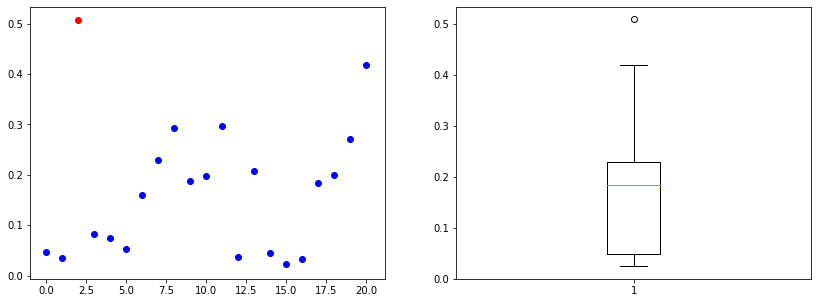

In [111]:
plt.figure(figsize=(14,5))
i = 0
plt.subplot(1,2,1)
for key in d_cv:
    if d_cv[key] <= upper_hkg:
        plt.scatter(i, d_cv[key], color="blue");
    else:
        plt.scatter(i, d_cv[key], color="red");
    i += 1
plt.subplot(1,2,2)
a = plt.boxplot(d_cv.values());

In [112]:
print("max cv: ", upper_hkg)
print("------------ outliers -------------")
for key, val in d_cv.items():
    if val >= upper_hkg:
        print(key, val)

max cv:  0.5005366248219769
------------ outliers -------------
idnT 0.5082800362135752


In [113]:
X_train = X_train.drop("idnT")
X_train.shape

(20, 9)

### data scaling

In [114]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


### One-classification

In [115]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(250, input_shape=(self.noise_input,)))
        model.add(Dense(250))
        model.add(Dense(250))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [116]:
noise_input = 18
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  18


In [117]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0],noise_input))
print("Dimension de los datos de entrada:", noise.shape)
data_fake = G.predict(noise)
print("Dimension de los ejemplos generados:", data_fake.shape)

Dimension de los datos de entrada: (20, 18)
Dimension de los ejemplos generados: (20, 9)


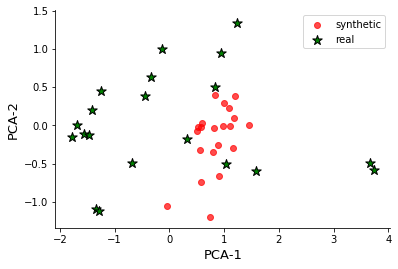

In [119]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)
X_train_pca
noise = np.random.normal(loc=0, scale=1, size=(21,noise_input))
fig1 = plt.figure(figsize=(6,4))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
#plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("PCA-1", fontsize=13)
plt.ylabel("PCA-2", fontsize=13)
x_noise = G.predict(noise)
X_fake_pca = pca_real.transform(x_noise)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="synthetic", alpha=.7)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [87]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [88]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

In [89]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [90]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [91]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    fscore = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_real = X_train.loc[np.random.choice(X_train.index.values, size=12, replace=False)]
        X_fake = G.predict(np.random.normal(0, 1, (12, noise_input)))
        X_test = np.concatenate((X_real, X_fake))
        y_test = np.concatenate((np.ones((12,1)), np.zeros((12,1))))
        y_predict = D.predict_classes(X_test)
        fscore.append(f1_score(y_test, y_predict))
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
    return g_loss, d_loss, fscore

In [120]:
noise_input = 100
#Gerador
#optimizerG = Adam(lr=0.0001, beta_1=0.4)
optimizerG = SGD(lr=0.0001, momentum=0.9, decay=0.0001/2000)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
#optimizerD = Adam(lr=0.002, beta_1=0.9)
optimizerD = SGD(lr=0.002, momentum=0.9, decay=0.002/2000)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  100
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_16 (Sequential)   (None, 9)                 153009    
_________________________________________________________________
sequential_17 (Sequential)   (None, 1)                 353       
Total params: 153,362
Trainable params: 153,009
Non-trainable params: 353
_________________________________________________________________


In [133]:
datos.shape[0]-21

4272

In [121]:
ep = 2000
g_loss, d_loss, fscore = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/2000] [Discriminator::d_loss: 0.640978],[Generator::loss: 0.609788], 1.955561[sec]
epoch:[2/2000] [Discriminator::d_loss: 0.685564],[Generator::loss: 0.693504], 0.013807[sec]
epoch:[3/2000] [Discriminator::d_loss: 0.691190],[Generator::loss: 0.721294], 0.013889[sec]
epoch:[4/2000] [Discriminator::d_loss: 0.705746],[Generator::loss: 0.776664], 0.013721[sec]
epoch:[5/2000] [Discriminator::d_loss: 0.683686],[Generator::loss: 0.791165], 0.013675[sec]
epoch:[6/2000] [Discriminator::d_loss: 0.762582],[Generator::loss: 0.741858], 0.013974[sec]
epoch:[7/2000] [Discriminator::d_loss: 0.671038],[Generator::loss: 0.756197], 0.013777[sec]
epoch:[8/2000] [Discriminator::d_loss: 0.683353],[Generator::loss: 0.675388], 0.013800[sec]
epoch:[9/2000] [Discriminator::d_loss: 0.647469],[Generator::loss: 0.710165], 0.014492[sec]
epoch:[10/2000] [Discriminator::d_loss: 0.715100],[Generator::loss: 0.667475], 0.013586[sec]
epoch:[11/2000] [Discriminator::d_loss: 0.647314],[Generator::loss: 0.764913], 

epoch:[91/2000] [Discriminator::d_loss: 0.627858],[Generator::loss: 0.709782], 0.018428[sec]
epoch:[92/2000] [Discriminator::d_loss: 0.626085],[Generator::loss: 0.791701], 0.021589[sec]
epoch:[93/2000] [Discriminator::d_loss: 0.574438],[Generator::loss: 0.800210], 0.022735[sec]
epoch:[94/2000] [Discriminator::d_loss: 0.620309],[Generator::loss: 0.813707], 0.014020[sec]
epoch:[95/2000] [Discriminator::d_loss: 0.628186],[Generator::loss: 0.674660], 0.013601[sec]
epoch:[96/2000] [Discriminator::d_loss: 0.615556],[Generator::loss: 0.794160], 0.013827[sec]
epoch:[97/2000] [Discriminator::d_loss: 0.626569],[Generator::loss: 0.759408], 0.013536[sec]
epoch:[98/2000] [Discriminator::d_loss: 0.599898],[Generator::loss: 0.789646], 0.013727[sec]
epoch:[99/2000] [Discriminator::d_loss: 0.636488],[Generator::loss: 0.777802], 0.013846[sec]
epoch:[100/2000] [Discriminator::d_loss: 0.606380],[Generator::loss: 0.672958], 0.014100[sec]
epoch:[101/2000] [Discriminator::d_loss: 0.644046],[Generator::loss: 

epoch:[189/2000] [Discriminator::d_loss: 0.655672],[Generator::loss: 0.769989], 0.019006[sec]
epoch:[190/2000] [Discriminator::d_loss: 0.565669],[Generator::loss: 0.827377], 0.016822[sec]
epoch:[191/2000] [Discriminator::d_loss: 0.559993],[Generator::loss: 0.788302], 0.014541[sec]
epoch:[192/2000] [Discriminator::d_loss: 0.565930],[Generator::loss: 0.780402], 0.015262[sec]
epoch:[193/2000] [Discriminator::d_loss: 0.551828],[Generator::loss: 0.781949], 0.016333[sec]
epoch:[194/2000] [Discriminator::d_loss: 0.559908],[Generator::loss: 0.766251], 0.016618[sec]
epoch:[195/2000] [Discriminator::d_loss: 0.553057],[Generator::loss: 0.763528], 0.016279[sec]
epoch:[196/2000] [Discriminator::d_loss: 0.556351],[Generator::loss: 0.772911], 0.015609[sec]
epoch:[197/2000] [Discriminator::d_loss: 0.609638],[Generator::loss: 0.732412], 0.014623[sec]
epoch:[198/2000] [Discriminator::d_loss: 0.547510],[Generator::loss: 0.802861], 0.015190[sec]
epoch:[199/2000] [Discriminator::d_loss: 0.607498],[Generato

epoch:[286/2000] [Discriminator::d_loss: 0.564042],[Generator::loss: 0.898421], 0.017832[sec]
epoch:[287/2000] [Discriminator::d_loss: 0.529678],[Generator::loss: 0.939618], 0.016485[sec]
epoch:[288/2000] [Discriminator::d_loss: 0.571231],[Generator::loss: 0.984772], 0.014145[sec]
epoch:[289/2000] [Discriminator::d_loss: 0.560322],[Generator::loss: 0.864420], 0.013720[sec]
epoch:[290/2000] [Discriminator::d_loss: 0.584255],[Generator::loss: 0.846789], 0.014379[sec]
epoch:[291/2000] [Discriminator::d_loss: 0.541326],[Generator::loss: 0.870938], 0.013714[sec]
epoch:[292/2000] [Discriminator::d_loss: 0.531643],[Generator::loss: 0.908060], 0.014090[sec]
epoch:[293/2000] [Discriminator::d_loss: 0.567212],[Generator::loss: 0.938701], 0.014000[sec]
epoch:[294/2000] [Discriminator::d_loss: 0.533284],[Generator::loss: 0.908273], 0.013766[sec]
epoch:[295/2000] [Discriminator::d_loss: 0.571769],[Generator::loss: 0.956014], 0.014372[sec]
epoch:[296/2000] [Discriminator::d_loss: 0.517451],[Generato

epoch:[385/2000] [Discriminator::d_loss: 0.546627],[Generator::loss: 0.902557], 0.014299[sec]
epoch:[386/2000] [Discriminator::d_loss: 0.537181],[Generator::loss: 0.824865], 0.019067[sec]
epoch:[387/2000] [Discriminator::d_loss: 0.520288],[Generator::loss: 0.959334], 0.014414[sec]
epoch:[388/2000] [Discriminator::d_loss: 0.588782],[Generator::loss: 0.869569], 0.013846[sec]
epoch:[389/2000] [Discriminator::d_loss: 0.537023],[Generator::loss: 0.839982], 0.013834[sec]
epoch:[390/2000] [Discriminator::d_loss: 0.540500],[Generator::loss: 1.018889], 0.013896[sec]
epoch:[391/2000] [Discriminator::d_loss: 0.506435],[Generator::loss: 0.823026], 0.013578[sec]
epoch:[392/2000] [Discriminator::d_loss: 0.491759],[Generator::loss: 0.922156], 0.013795[sec]
epoch:[393/2000] [Discriminator::d_loss: 0.508070],[Generator::loss: 0.956662], 0.013753[sec]
epoch:[394/2000] [Discriminator::d_loss: 0.553426],[Generator::loss: 0.854537], 0.013644[sec]
epoch:[395/2000] [Discriminator::d_loss: 0.517419],[Generato

epoch:[485/2000] [Discriminator::d_loss: 0.555577],[Generator::loss: 0.954332], 0.014857[sec]
epoch:[486/2000] [Discriminator::d_loss: 0.524817],[Generator::loss: 0.909731], 0.017402[sec]
epoch:[487/2000] [Discriminator::d_loss: 0.599635],[Generator::loss: 0.843878], 0.013915[sec]
epoch:[488/2000] [Discriminator::d_loss: 0.539200],[Generator::loss: 0.931474], 0.014692[sec]
epoch:[489/2000] [Discriminator::d_loss: 0.590693],[Generator::loss: 0.940090], 0.013520[sec]
epoch:[490/2000] [Discriminator::d_loss: 0.519214],[Generator::loss: 0.941729], 0.013918[sec]
epoch:[491/2000] [Discriminator::d_loss: 0.517237],[Generator::loss: 0.873535], 0.015437[sec]
epoch:[492/2000] [Discriminator::d_loss: 0.567103],[Generator::loss: 0.958824], 0.014844[sec]
epoch:[493/2000] [Discriminator::d_loss: 0.552159],[Generator::loss: 0.897955], 0.014288[sec]
epoch:[494/2000] [Discriminator::d_loss: 0.539889],[Generator::loss: 0.857331], 0.015687[sec]
epoch:[495/2000] [Discriminator::d_loss: 0.529852],[Generato

epoch:[583/2000] [Discriminator::d_loss: 0.579538],[Generator::loss: 0.944684], 0.015080[sec]
epoch:[584/2000] [Discriminator::d_loss: 0.549342],[Generator::loss: 0.831225], 0.016239[sec]
epoch:[585/2000] [Discriminator::d_loss: 0.568425],[Generator::loss: 0.889217], 0.014738[sec]
epoch:[586/2000] [Discriminator::d_loss: 0.592046],[Generator::loss: 0.816401], 0.014128[sec]
epoch:[587/2000] [Discriminator::d_loss: 0.600294],[Generator::loss: 0.965122], 0.013740[sec]
epoch:[588/2000] [Discriminator::d_loss: 0.603532],[Generator::loss: 0.930949], 0.013819[sec]
epoch:[589/2000] [Discriminator::d_loss: 0.538440],[Generator::loss: 1.011338], 0.013989[sec]
epoch:[590/2000] [Discriminator::d_loss: 0.528279],[Generator::loss: 0.873200], 0.013960[sec]
epoch:[591/2000] [Discriminator::d_loss: 0.558531],[Generator::loss: 0.932193], 0.013934[sec]
epoch:[592/2000] [Discriminator::d_loss: 0.567545],[Generator::loss: 0.815075], 0.014385[sec]
epoch:[593/2000] [Discriminator::d_loss: 0.581878],[Generato

epoch:[683/2000] [Discriminator::d_loss: 0.624914],[Generator::loss: 1.039934], 0.017689[sec]
epoch:[684/2000] [Discriminator::d_loss: 0.646232],[Generator::loss: 0.891169], 0.019048[sec]
epoch:[685/2000] [Discriminator::d_loss: 0.632106],[Generator::loss: 0.832820], 0.014634[sec]
epoch:[686/2000] [Discriminator::d_loss: 0.591108],[Generator::loss: 0.752920], 0.017488[sec]
epoch:[687/2000] [Discriminator::d_loss: 0.619078],[Generator::loss: 0.861316], 0.018154[sec]
epoch:[688/2000] [Discriminator::d_loss: 0.648794],[Generator::loss: 0.839218], 0.018326[sec]
epoch:[689/2000] [Discriminator::d_loss: 0.545142],[Generator::loss: 0.898940], 0.021226[sec]
epoch:[690/2000] [Discriminator::d_loss: 0.551351],[Generator::loss: 0.940855], 0.016739[sec]
epoch:[691/2000] [Discriminator::d_loss: 0.566530],[Generator::loss: 0.894971], 0.018141[sec]
epoch:[692/2000] [Discriminator::d_loss: 0.566495],[Generator::loss: 0.746104], 0.019694[sec]
epoch:[693/2000] [Discriminator::d_loss: 0.580552],[Generato

epoch:[783/2000] [Discriminator::d_loss: 0.659161],[Generator::loss: 1.001673], 0.015203[sec]
epoch:[784/2000] [Discriminator::d_loss: 0.653516],[Generator::loss: 0.807577], 0.016415[sec]
epoch:[785/2000] [Discriminator::d_loss: 0.593007],[Generator::loss: 0.859402], 0.016977[sec]
epoch:[786/2000] [Discriminator::d_loss: 0.668028],[Generator::loss: 1.036124], 0.014074[sec]
epoch:[787/2000] [Discriminator::d_loss: 0.663236],[Generator::loss: 0.775461], 0.014679[sec]
epoch:[788/2000] [Discriminator::d_loss: 0.651489],[Generator::loss: 0.860801], 0.014971[sec]
epoch:[789/2000] [Discriminator::d_loss: 0.622021],[Generator::loss: 0.736515], 0.014358[sec]
epoch:[790/2000] [Discriminator::d_loss: 0.621576],[Generator::loss: 0.841338], 0.013734[sec]
epoch:[791/2000] [Discriminator::d_loss: 0.646685],[Generator::loss: 0.795916], 0.013699[sec]
epoch:[792/2000] [Discriminator::d_loss: 0.648988],[Generator::loss: 0.802972], 0.013795[sec]
epoch:[793/2000] [Discriminator::d_loss: 0.632305],[Generato

epoch:[881/2000] [Discriminator::d_loss: 0.642370],[Generator::loss: 0.914666], 0.015443[sec]
epoch:[882/2000] [Discriminator::d_loss: 0.598673],[Generator::loss: 0.747536], 0.016240[sec]
epoch:[883/2000] [Discriminator::d_loss: 0.652752],[Generator::loss: 0.950035], 0.014479[sec]
epoch:[884/2000] [Discriminator::d_loss: 0.671368],[Generator::loss: 0.885017], 0.014079[sec]
epoch:[885/2000] [Discriminator::d_loss: 0.652013],[Generator::loss: 0.957915], 0.013903[sec]
epoch:[886/2000] [Discriminator::d_loss: 0.708708],[Generator::loss: 0.736320], 0.013680[sec]
epoch:[887/2000] [Discriminator::d_loss: 0.722809],[Generator::loss: 0.954580], 0.014103[sec]
epoch:[888/2000] [Discriminator::d_loss: 0.628413],[Generator::loss: 0.788113], 0.013952[sec]
epoch:[889/2000] [Discriminator::d_loss: 0.565984],[Generator::loss: 0.680635], 0.014143[sec]
epoch:[890/2000] [Discriminator::d_loss: 0.658861],[Generator::loss: 0.837721], 0.021245[sec]
epoch:[891/2000] [Discriminator::d_loss: 0.626098],[Generato

epoch:[976/2000] [Discriminator::d_loss: 0.675905],[Generator::loss: 0.757826], 0.015241[sec]
epoch:[977/2000] [Discriminator::d_loss: 0.669219],[Generator::loss: 0.801810], 0.016499[sec]
epoch:[978/2000] [Discriminator::d_loss: 0.660076],[Generator::loss: 0.869693], 0.014482[sec]
epoch:[979/2000] [Discriminator::d_loss: 0.694625],[Generator::loss: 0.871804], 0.014095[sec]
epoch:[980/2000] [Discriminator::d_loss: 0.645504],[Generator::loss: 0.834437], 0.013402[sec]
epoch:[981/2000] [Discriminator::d_loss: 0.724303],[Generator::loss: 0.796255], 0.013679[sec]
epoch:[982/2000] [Discriminator::d_loss: 0.718453],[Generator::loss: 0.782277], 0.013776[sec]
epoch:[983/2000] [Discriminator::d_loss: 0.634500],[Generator::loss: 0.762704], 0.013713[sec]
epoch:[984/2000] [Discriminator::d_loss: 0.650120],[Generator::loss: 0.783745], 0.013983[sec]
epoch:[985/2000] [Discriminator::d_loss: 0.664261],[Generator::loss: 0.777212], 0.013926[sec]
epoch:[986/2000] [Discriminator::d_loss: 0.678289],[Generato

epoch:[1076/2000] [Discriminator::d_loss: 0.726355],[Generator::loss: 0.820371], 0.015846[sec]
epoch:[1077/2000] [Discriminator::d_loss: 0.653907],[Generator::loss: 0.799796], 0.018162[sec]
epoch:[1078/2000] [Discriminator::d_loss: 0.739023],[Generator::loss: 0.906327], 0.013916[sec]
epoch:[1079/2000] [Discriminator::d_loss: 0.709404],[Generator::loss: 0.854928], 0.013880[sec]
epoch:[1080/2000] [Discriminator::d_loss: 0.693919],[Generator::loss: 0.793717], 0.013984[sec]
epoch:[1081/2000] [Discriminator::d_loss: 0.615842],[Generator::loss: 0.737182], 0.013700[sec]
epoch:[1082/2000] [Discriminator::d_loss: 0.686641],[Generator::loss: 0.771812], 0.013991[sec]
epoch:[1083/2000] [Discriminator::d_loss: 0.701097],[Generator::loss: 0.816117], 0.013619[sec]
epoch:[1084/2000] [Discriminator::d_loss: 0.686786],[Generator::loss: 0.802636], 0.015316[sec]
epoch:[1085/2000] [Discriminator::d_loss: 0.720576],[Generator::loss: 0.770478], 0.015847[sec]
epoch:[1086/2000] [Discriminator::d_loss: 0.692440

epoch:[1165/2000] [Discriminator::d_loss: 0.691320],[Generator::loss: 0.826430], 0.022859[sec]
epoch:[1166/2000] [Discriminator::d_loss: 0.699052],[Generator::loss: 0.795084], 0.016457[sec]
epoch:[1167/2000] [Discriminator::d_loss: 0.718612],[Generator::loss: 0.785748], 0.013934[sec]
epoch:[1168/2000] [Discriminator::d_loss: 0.765579],[Generator::loss: 0.793561], 0.013662[sec]
epoch:[1169/2000] [Discriminator::d_loss: 0.735285],[Generator::loss: 0.756310], 0.014100[sec]
epoch:[1170/2000] [Discriminator::d_loss: 0.697169],[Generator::loss: 0.788632], 0.013620[sec]
epoch:[1171/2000] [Discriminator::d_loss: 0.733317],[Generator::loss: 0.724015], 0.013884[sec]
epoch:[1172/2000] [Discriminator::d_loss: 0.752953],[Generator::loss: 0.885228], 0.013761[sec]
epoch:[1173/2000] [Discriminator::d_loss: 0.683203],[Generator::loss: 0.865000], 0.013886[sec]
epoch:[1174/2000] [Discriminator::d_loss: 0.684282],[Generator::loss: 0.825782], 0.013672[sec]
epoch:[1175/2000] [Discriminator::d_loss: 0.730048

epoch:[1264/2000] [Discriminator::d_loss: 0.671400],[Generator::loss: 0.849396], 0.019817[sec]
epoch:[1265/2000] [Discriminator::d_loss: 0.673546],[Generator::loss: 0.707727], 0.014307[sec]
epoch:[1266/2000] [Discriminator::d_loss: 0.658179],[Generator::loss: 0.743557], 0.014664[sec]
epoch:[1267/2000] [Discriminator::d_loss: 0.660448],[Generator::loss: 0.809800], 0.013502[sec]
epoch:[1268/2000] [Discriminator::d_loss: 0.724557],[Generator::loss: 0.748181], 0.014220[sec]
epoch:[1269/2000] [Discriminator::d_loss: 0.694644],[Generator::loss: 0.684770], 0.013945[sec]
epoch:[1270/2000] [Discriminator::d_loss: 0.649001],[Generator::loss: 0.692574], 0.014441[sec]
epoch:[1271/2000] [Discriminator::d_loss: 0.640841],[Generator::loss: 0.736283], 0.014390[sec]
epoch:[1272/2000] [Discriminator::d_loss: 0.747316],[Generator::loss: 0.900413], 0.014363[sec]
epoch:[1273/2000] [Discriminator::d_loss: 0.738069],[Generator::loss: 0.747764], 0.014402[sec]
epoch:[1274/2000] [Discriminator::d_loss: 0.747392

epoch:[1364/2000] [Discriminator::d_loss: 0.710077],[Generator::loss: 0.783139], 0.015045[sec]
epoch:[1365/2000] [Discriminator::d_loss: 0.680677],[Generator::loss: 0.745412], 0.016188[sec]
epoch:[1366/2000] [Discriminator::d_loss: 0.694746],[Generator::loss: 0.770636], 0.014960[sec]
epoch:[1367/2000] [Discriminator::d_loss: 0.678662],[Generator::loss: 0.822266], 0.013730[sec]
epoch:[1368/2000] [Discriminator::d_loss: 0.690602],[Generator::loss: 0.756931], 0.013697[sec]
epoch:[1369/2000] [Discriminator::d_loss: 0.721202],[Generator::loss: 0.800229], 0.013726[sec]
epoch:[1370/2000] [Discriminator::d_loss: 0.710748],[Generator::loss: 0.774084], 0.013593[sec]
epoch:[1371/2000] [Discriminator::d_loss: 0.655604],[Generator::loss: 0.773378], 0.013541[sec]
epoch:[1372/2000] [Discriminator::d_loss: 0.674660],[Generator::loss: 0.801882], 0.013645[sec]
epoch:[1373/2000] [Discriminator::d_loss: 0.690329],[Generator::loss: 0.728970], 0.014068[sec]
epoch:[1374/2000] [Discriminator::d_loss: 0.685050

epoch:[1453/2000] [Discriminator::d_loss: 0.656968],[Generator::loss: 0.815825], 0.020815[sec]
epoch:[1454/2000] [Discriminator::d_loss: 0.639092],[Generator::loss: 0.775608], 0.013760[sec]
epoch:[1455/2000] [Discriminator::d_loss: 0.685210],[Generator::loss: 0.764773], 0.013908[sec]
epoch:[1456/2000] [Discriminator::d_loss: 0.703438],[Generator::loss: 0.810981], 0.013834[sec]
epoch:[1457/2000] [Discriminator::d_loss: 0.695322],[Generator::loss: 0.773402], 0.013933[sec]
epoch:[1458/2000] [Discriminator::d_loss: 0.657330],[Generator::loss: 0.778985], 0.013529[sec]
epoch:[1459/2000] [Discriminator::d_loss: 0.675215],[Generator::loss: 0.750508], 0.013769[sec]
epoch:[1460/2000] [Discriminator::d_loss: 0.690414],[Generator::loss: 0.777721], 0.014146[sec]
epoch:[1461/2000] [Discriminator::d_loss: 0.667387],[Generator::loss: 0.686308], 0.013451[sec]
epoch:[1462/2000] [Discriminator::d_loss: 0.712718],[Generator::loss: 0.710698], 0.013803[sec]
epoch:[1463/2000] [Discriminator::d_loss: 0.709216

epoch:[1543/2000] [Discriminator::d_loss: 0.662486],[Generator::loss: 0.716035], 0.020927[sec]
epoch:[1544/2000] [Discriminator::d_loss: 0.673864],[Generator::loss: 0.768527], 0.014641[sec]
epoch:[1545/2000] [Discriminator::d_loss: 0.689046],[Generator::loss: 0.774764], 0.014103[sec]
epoch:[1546/2000] [Discriminator::d_loss: 0.667660],[Generator::loss: 0.721287], 0.013928[sec]
epoch:[1547/2000] [Discriminator::d_loss: 0.693737],[Generator::loss: 0.732866], 0.013648[sec]
epoch:[1548/2000] [Discriminator::d_loss: 0.687093],[Generator::loss: 0.841942], 0.013608[sec]
epoch:[1549/2000] [Discriminator::d_loss: 0.669710],[Generator::loss: 0.745658], 0.013783[sec]
epoch:[1550/2000] [Discriminator::d_loss: 0.696421],[Generator::loss: 0.723752], 0.013594[sec]
epoch:[1551/2000] [Discriminator::d_loss: 0.679968],[Generator::loss: 0.809648], 0.014115[sec]
epoch:[1552/2000] [Discriminator::d_loss: 0.664288],[Generator::loss: 0.767740], 0.018978[sec]
epoch:[1553/2000] [Discriminator::d_loss: 0.668129

epoch:[1632/2000] [Discriminator::d_loss: 0.662048],[Generator::loss: 0.738165], 0.017546[sec]
epoch:[1633/2000] [Discriminator::d_loss: 0.676600],[Generator::loss: 0.738126], 0.015068[sec]
epoch:[1634/2000] [Discriminator::d_loss: 0.651025],[Generator::loss: 0.806945], 0.013822[sec]
epoch:[1635/2000] [Discriminator::d_loss: 0.676423],[Generator::loss: 0.749018], 0.013980[sec]
epoch:[1636/2000] [Discriminator::d_loss: 0.670963],[Generator::loss: 0.781100], 0.013770[sec]
epoch:[1637/2000] [Discriminator::d_loss: 0.681740],[Generator::loss: 0.800547], 0.014352[sec]
epoch:[1638/2000] [Discriminator::d_loss: 0.669457],[Generator::loss: 0.734459], 0.013576[sec]
epoch:[1639/2000] [Discriminator::d_loss: 0.682512],[Generator::loss: 0.782659], 0.013960[sec]
epoch:[1640/2000] [Discriminator::d_loss: 0.674768],[Generator::loss: 0.761334], 0.013572[sec]
epoch:[1641/2000] [Discriminator::d_loss: 0.660881],[Generator::loss: 0.792055], 0.013690[sec]
epoch:[1642/2000] [Discriminator::d_loss: 0.670649

epoch:[1720/2000] [Discriminator::d_loss: 0.680160],[Generator::loss: 0.716889], 0.026128[sec]
epoch:[1721/2000] [Discriminator::d_loss: 0.672944],[Generator::loss: 0.767522], 0.015309[sec]
epoch:[1722/2000] [Discriminator::d_loss: 0.661111],[Generator::loss: 0.757270], 0.033162[sec]
epoch:[1723/2000] [Discriminator::d_loss: 0.668222],[Generator::loss: 0.743548], 0.018395[sec]
epoch:[1724/2000] [Discriminator::d_loss: 0.703281],[Generator::loss: 0.783506], 0.024067[sec]
epoch:[1725/2000] [Discriminator::d_loss: 0.695312],[Generator::loss: 0.737213], 0.018582[sec]
epoch:[1726/2000] [Discriminator::d_loss: 0.674637],[Generator::loss: 0.743760], 0.016880[sec]
epoch:[1727/2000] [Discriminator::d_loss: 0.671269],[Generator::loss: 0.774549], 0.022584[sec]
epoch:[1728/2000] [Discriminator::d_loss: 0.665961],[Generator::loss: 0.783269], 0.014443[sec]
epoch:[1729/2000] [Discriminator::d_loss: 0.683245],[Generator::loss: 0.763287], 0.013423[sec]
epoch:[1730/2000] [Discriminator::d_loss: 0.689316

epoch:[1818/2000] [Discriminator::d_loss: 0.659813],[Generator::loss: 0.754715], 0.014929[sec]
epoch:[1819/2000] [Discriminator::d_loss: 0.673707],[Generator::loss: 0.732127], 0.018750[sec]
epoch:[1820/2000] [Discriminator::d_loss: 0.682065],[Generator::loss: 0.719383], 0.014656[sec]
epoch:[1821/2000] [Discriminator::d_loss: 0.672998],[Generator::loss: 0.695157], 0.013870[sec]
epoch:[1822/2000] [Discriminator::d_loss: 0.682509],[Generator::loss: 0.768847], 0.014192[sec]
epoch:[1823/2000] [Discriminator::d_loss: 0.660463],[Generator::loss: 0.724185], 0.013783[sec]
epoch:[1824/2000] [Discriminator::d_loss: 0.661258],[Generator::loss: 0.759090], 0.013630[sec]
epoch:[1825/2000] [Discriminator::d_loss: 0.672563],[Generator::loss: 0.720368], 0.013743[sec]
epoch:[1826/2000] [Discriminator::d_loss: 0.684296],[Generator::loss: 0.753370], 0.013294[sec]
epoch:[1827/2000] [Discriminator::d_loss: 0.690480],[Generator::loss: 0.769655], 0.017239[sec]
epoch:[1828/2000] [Discriminator::d_loss: 0.702603

epoch:[1918/2000] [Discriminator::d_loss: 0.695559],[Generator::loss: 0.787197], 0.019420[sec]
epoch:[1919/2000] [Discriminator::d_loss: 0.673914],[Generator::loss: 0.771981], 0.014333[sec]
epoch:[1920/2000] [Discriminator::d_loss: 0.654253],[Generator::loss: 0.768690], 0.013875[sec]
epoch:[1921/2000] [Discriminator::d_loss: 0.666191],[Generator::loss: 0.749976], 0.013811[sec]
epoch:[1922/2000] [Discriminator::d_loss: 0.664733],[Generator::loss: 0.741719], 0.014458[sec]
epoch:[1923/2000] [Discriminator::d_loss: 0.689751],[Generator::loss: 0.806669], 0.013687[sec]
epoch:[1924/2000] [Discriminator::d_loss: 0.677912],[Generator::loss: 0.729063], 0.014039[sec]
epoch:[1925/2000] [Discriminator::d_loss: 0.688561],[Generator::loss: 0.723774], 0.013453[sec]
epoch:[1926/2000] [Discriminator::d_loss: 0.692064],[Generator::loss: 0.745596], 0.013945[sec]
epoch:[1927/2000] [Discriminator::d_loss: 0.689394],[Generator::loss: 0.696687], 0.013731[sec]
epoch:[1928/2000] [Discriminator::d_loss: 0.663918

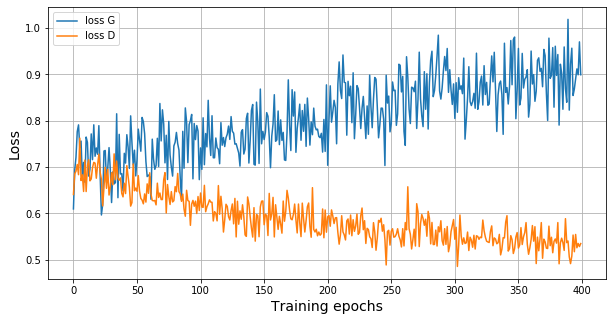

In [131]:
plt.figure(figsize=(10,5))
#plt.title("Loss GAN", fontsize=15)
plt.plot(range(ep)[:400], g_loss[:400], label="loss G")
plt.plot(range(ep)[:400], d_loss[:400], label="loss D")
plt.xlabel("Training epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid()
plt.legend();

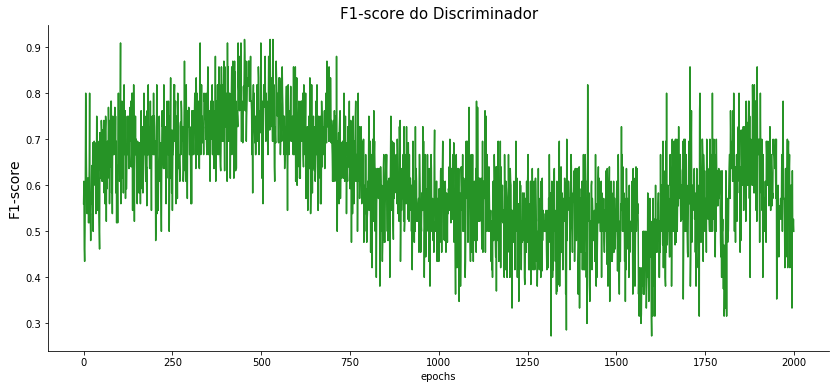

In [130]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("F1-score do Discriminador", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("F1-score", fontsize=14)
plt.plot(range(len(fscore)), fscore, color="green", alpha=.85);

(20, 2) (21, 2)


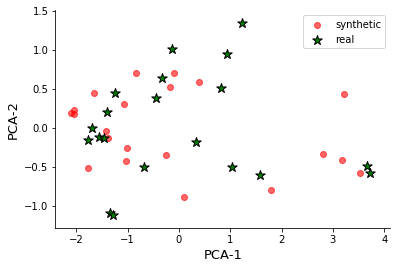

In [124]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(21,noise_input)))
X_fake_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_fake_pca.shape)
#plt.title("2-PCA entre dados reais e fakes", fontsize=14)
plt.xlabel("PCA-1", fontsize=13)
plt.ylabel("PCA-2", fontsize=13)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="synthetic", alpha=0.8)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [ ]:
cof
cyoC
fnr
focA
gatA
gcvT
gnd
mprA
nuoA
nuoE
nuoJ
nuoM
panD
pck
pepD
pldB
ptsH
rcsB
rfbB
rplA
rplK
rpoZ
sspA
tolC
xseB
ybaB
ybbN
ybeX
ydgJ
yeaD
ygiB
ylaC

In [164]:
rg = ["ylaC", "yeaD","ygiB","gcvT", "rplK", "ybbN", "tolC", "nuoA", "nuoE","fnr",
     "cyoC", "gnd", "mprA", "pck", "ydgJ"]

In [172]:
for i in rg:
    print(i, np.round(np.std(datos.loc[i].values)/np.mean(datos.loc[i].values),4))

ylaC 0.0345
yeaD 0.3283
ygiB 0.2151
gcvT 0.2203
rplK 0.2206
ybbN 0.0338
tolC 0.3223
nuoA 0.2745
nuoE 0.1574
fnr 0.2215
cyoC 0.2899
gnd 0.2428
mprA 0.245
pck 0.3005
ydgJ 0.3625
